In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 74s 24ms/step - loss: 0.5946 - acc: 0.8562 - val_loss: 0.3213 - val_acc: 0.9123
Epoch 2/100
3144/3144 [==============================] - 67s 21ms/step - loss: 0.2760 - acc: 0.9135 - val_loss: 0.4615 - val_acc: 0.7637
Epoch 3/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.2747 - acc: 0.9157 - val_loss: 0.2386 - val_acc: 0.9365
Epoch 4/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.2992 - acc: 0.8973 - val_loss: 0.4245 - val_acc: 0.9187
Epoch 5/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.1688 - acc: 0.9517 - val_loss: 0.3648 - val_acc: 0.8221
Epoch 6/100
3144/3144 [==============================] - 71s 22ms/step - loss: 0.1774 - acc: 0.9450 - val_loss: 0.6039 - val_acc: 0.8145
Epoch 7/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.0987 - acc: 0.9701 - val_loss: 0.2563 - val_acc: 0

3144/3144 [==============================] - 70s 22ms/step - loss: 0.0450 - acc: 0.9866 - val_loss: 0.1610 - val_acc: 0.9454
Epoch 61/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.0304 - acc: 0.9889 - val_loss: 0.1939 - val_acc: 0.9555
Epoch 62/100
3144/3144 [==============================] - 69s 22ms/step - loss: 0.0293 - acc: 0.9892 - val_loss: 0.3167 - val_acc: 0.9327
Epoch 63/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.0210 - acc: 0.9920 - val_loss: 0.2600 - val_acc: 0.9479
Epoch 64/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.0362 - acc: 0.9892 - val_loss: 0.2760 - val_acc: 0.9339
Epoch 65/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.0537 - acc: 0.9803 - val_loss: 0.3319 - val_acc: 0.9403
Epoch 66/100
3144/3144 [==============================] - 76s 24ms/step - loss: 0.0303 - acc: 0.9873 - val_loss: 0.2385 - val_acc: 0.9504
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 76s 24ms/step - loss: 0.2486 - acc: 0.9161 - val_loss: 0.3988 - val_acc: 0.8842
Epoch 19/100
3145/3145 [==============================] - 79s 25ms/step - loss: 0.2319 - acc: 0.9275 - val_loss: 0.2164 - val_acc: 0.9237
Epoch 20/100
3145/3145 [==============================] - 74s 24ms/step - loss: 0.2084 - acc: 0.9278 - val_loss: 0.2246 - val_acc: 0.9262
Epoch 21/100
3145/3145 [==============================] - 77s 25ms/step - loss: 0.2238 - acc: 0.9285 - val_loss: 0.3396 - val_acc: 0.8919
Epoch 22/100
3145/3145 [==============================] - 78s 25ms/step - loss: 0.1992 - acc: 0.9393 - val_loss: 0.2621 - val_acc: 0.8893
Epoch 23/100
3145/3145 [==============================] - 75s 24ms/step - loss: 0.1901 - acc: 0.9456 - val_loss: 0.2109 - val_acc: 0.9224
Epoch 24/100
3145/3145 [==============================] - 76s 24ms/step - loss: 0.1796 - acc: 0.9529 - val_loss: 0.2682 - val_acc: 0.9059
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 71s 23ms/step - loss: 0.0337 - acc: 0.9873 - val_loss: 0.2058 - val_acc: 0.9580
Epoch 78/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0184 - acc: 0.9936 - val_loss: 0.2244 - val_acc: 0.9606
Epoch 79/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.0113 - acc: 0.9949 - val_loss: 0.2476 - val_acc: 0.9542
Epoch 80/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.0198 - acc: 0.9943 - val_loss: 0.3896 - val_acc: 0.9262
Epoch 81/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.0245 - acc: 0.9924 - val_loss: 0.2978 - val_acc: 0.9529
Epoch 82/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.0227 - acc: 0.9917 - val_loss: 0.2481 - val_acc: 0.9478
Epoch 83/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0281 - acc: 0.9895 - val_loss: 0.2278 - val_acc: 0.9631
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 66s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 36/100
3145/3145 [==============================] - 69s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 37/100
3145/3145 [==============================] - 67s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 38/100
3145/3145 [==============================] - 68s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 39/100
3145/3145 [==============================] - 67s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 40/100
3145/3145 [==============================] - 66s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 41/100
3145/3145 [==============================] - 70s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 68s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 95/100
3145/3145 [==============================] - 68s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 96/100
3145/3145 [==============================] - 66s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 97/100
3145/3145 [==============================] - 69s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 98/100
3145/3145 [==============================] - 67s 21ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 99/100
3145/3145 [==============================] - 69s 22ms/step - loss: 8.1436 - acc: 0.4948 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 100/100
786/786 [==============================] - 8s 11ms/step
[2] Test acurracy: 0.4949 (6858.5633 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [=====

3145/3145 [==============================] - 69s 22ms/step - loss: 0.0298 - acc: 0.9898 - val_loss: 0.2607 - val_acc: 0.9237
Epoch 53/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.0149 - acc: 0.9962 - val_loss: 0.2066 - val_acc: 0.9555
Epoch 54/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.3198 - val_acc: 0.9529
Epoch 55/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0166 - acc: 0.9952 - val_loss: 0.3440 - val_acc: 0.9338
Epoch 56/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0310 - acc: 0.9895 - val_loss: 0.3016 - val_acc: 0.9415
Epoch 57/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0321 - acc: 0.9908 - val_loss: 0.2004 - val_acc: 0.9427
Epoch 58/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.2184 - val_acc: 0.9567
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 70s 22ms/step - loss: 0.5336 - acc: 0.8242 - val_loss: 6.7674 - val_acc: 0.4987
Epoch 11/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.4178 - acc: 0.8477 - val_loss: 0.3936 - val_acc: 0.8779
Epoch 12/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.3986 - acc: 0.8649 - val_loss: 0.7790 - val_acc: 0.7672
Epoch 13/100
3145/3145 [==============================] - 71s 22ms/step - loss: 0.3731 - acc: 0.8760 - val_loss: 0.2612 - val_acc: 0.9135
Epoch 14/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.2945 - acc: 0.8963 - val_loss: 0.2396 - val_acc: 0.9173
Epoch 15/100
3145/3145 [==============================] - 73s 23ms/step - loss: 0.2398 - acc: 0.9110 - val_loss: 0.2032 - val_acc: 0.9275
Epoch 16/100
3145/3145 [==============================] - 74s 23ms/step - loss: 0.2124 - acc: 0.9208 - val_loss: 0.1934 - val_acc: 0.9313
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 34s 11ms/step - loss: 0.0565 - acc: 0.9774 - val_loss: 0.2101 - val_acc: 0.9567
Epoch 70/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0258 - acc: 0.9895 - val_loss: 0.1733 - val_acc: 0.9529
Epoch 71/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.2071 - val_acc: 0.9491
Epoch 72/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.1432 - val_acc: 0.9567
Epoch 73/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0177 - acc: 0.9936 - val_loss: 0.1923 - val_acc: 0.9453
Epoch 74/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0292 - acc: 0.9898 - val_loss: 0.8069 - val_acc: 0.8155
Epoch 75/100
3145/3145 [==============================] - 34s 11ms/step - loss: 0.0515 - acc: 0.9825 - val_loss: 0.3478 - val_acc: 0.8944
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8662


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

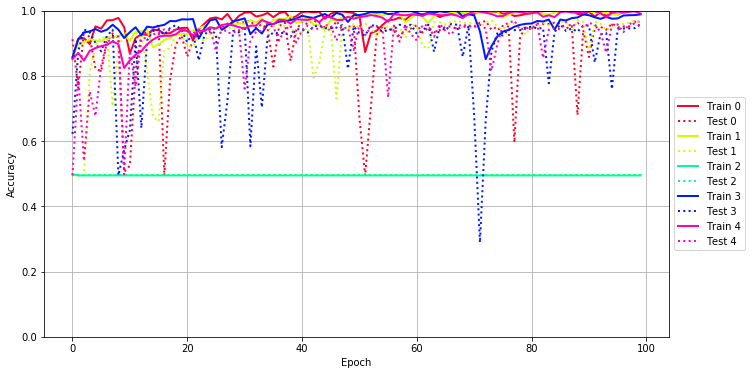

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

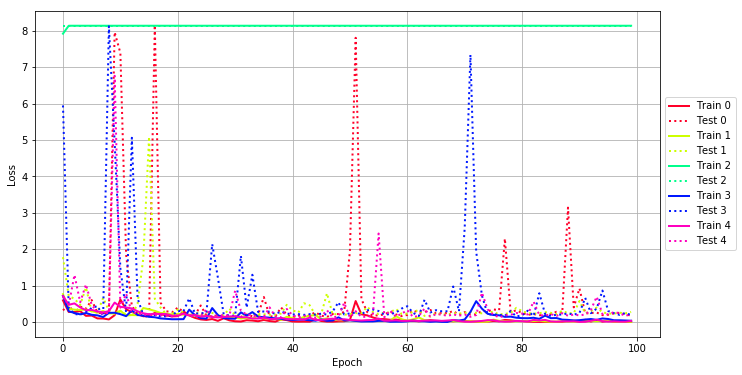

In [12]:
plot_loss(history)

Plotting the confusion matrix


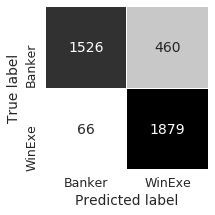

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


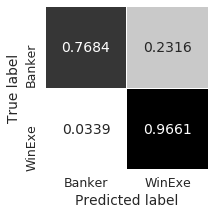

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'val_acc': [0.9123252869561183, 0.7636594667822464, 0.936467599005378, 0.9186785265784403, 0.8221092762607783, 0.8144853875476493, 0.9047013978643066, 0.9301143583227446, 0.9161372305174492, 0.5057179161372299, 0.5247776365946633, 0.8170266836086404, 0.9275730627919092, 0.9339263034745426, 0.9326556549138914, 0.9567979674933069, 0.49428208386277, 0.7865311308010107, 0.8958068607419994, 0.9237611187004225, 0.8589580680091015, 0.9097839908951271, 0.930114359383056, 0.9390088950663691, 0.9339263024142312, 0.9504447268106735, 0.947903431279838, 0.9606099115847936, 0.9580686155238024, 0.963151207115629, 0.9644218551461246, 0.9695044472681067, 0.9479034307496823, 0.9580686155238024, 0.9440914871883513, 0.8284625151257351, 0.9529860234018203, 0.963151207115629, 0.8462515875526728, 0.9402795430968647, 0.9669631512071156, 0.9580686155238024, 0.970775095828758, 0.9593392630241423, 0.9479034307496823, 0.9390088946876866, 0.9682337992376112, 0.9415501911273603, 0.9504447278709848, 0.9542566709021

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

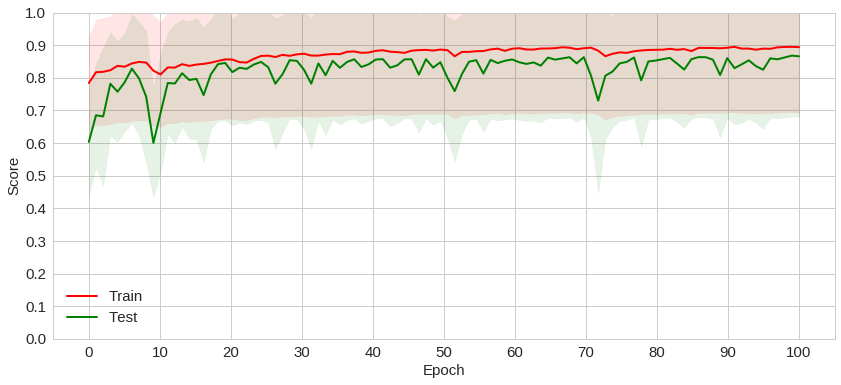

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

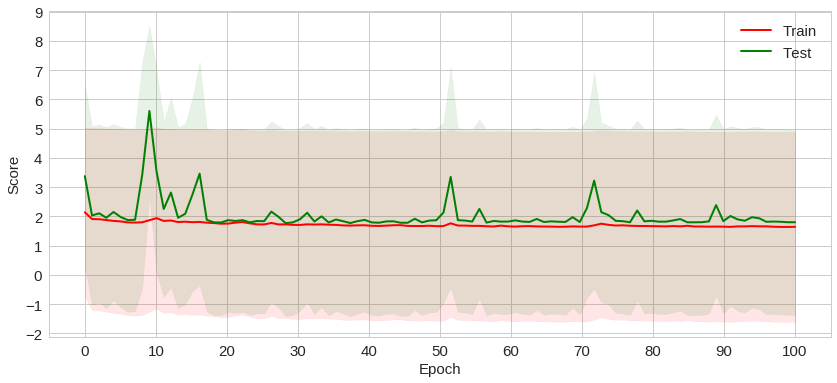

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'val_acc': [0.9123252869561183, 0.7636594667822464, 0.936467599005378, 0.9186785265784403, 0.8221092762607783, 0.8144853875476493, 0.9047013978643066, 0.9301143583227446, 0.9161372305174492, 0.5057179161372299, 0.5247776365946633, 0.8170266836086404, 0.9275730627919092, 0.9339263034745426, 0.9326556549138914, 0.9567979674933069, 0.49428208386277, 0.7865311308010107, 0.8958068607419994, 0.9237611187004225, 0.8589580680091015, 0.9097839908951271, 0.930114359383056, 0.9390088950663691, 0.9339263024142312, 0.9504447268106735, 0.947903431279838, 0.9606099115847936, 0.9580686155238024, 0.963151207115629, 0.9644218551461246, 0.9695044472681067, 0.9479034307496823, 0.9580686155238024, 0.9440914871883513, 0.8284625151257351, 0.9529860234018203, 0.963151207115629, 0.8462515875526728, 0.9402795430968647, 0.9669631512071156, 0.9580686155238024, 0.970775095828758, 0.9593392630241423, 0.9479034307496823, 0.9390088946876866, 0.9682337992376112, 0.9415501911273603, 0.9504447278709848, 0.9542566709021602, 0.6709021606318075, 0.49428208386277, 0.7052096574551875, 0.9263024147614136, 0.9466327827191868, 0.9440914866581956, 0.9377382465057179, 0.9212198222607488, 0.941550191657516, 0.9453621346886912, 0.9555273189326556, 0.9326556543837357, 0.947903431279838, 0.9339263029443869, 0.940279542566709, 0.9504447278709848, 0.951715374841169, 0.9440914871883513, 0.9491740787801779, 0.9542566709021602, 0.951715374841169, 0.963151207115629, 0.9682337992376112, 0.9415501905972046, 0.9504447268106735, 0.9275730622617535, 0.9542566714323157, 0.5959339263781508, 0.9212198221092758, 0.9466327837794981, 0.9428208391578558, 0.9606099110546379, 0.9593392630241423, 0.9593392630241423, 0.963151207115629, 0.9606099110546379, 0.9453621352188469, 0.9529860228716646, 0.6797966963908573, 0.9402795436270204, 0.8576874198271328, 0.947903431279838, 0.9504447268106735, 0.9415501905972046, 0.9606099110546379, 0.9491740793103336, 0.951715374841169, 0.9517153753713247, 0.9618805596152891, 0.9682337992376112], 'loss': [0.594647580354875, 0.27599538957496333, 0.2746771533260212, 0.2991966861880766, 0.16876610142887397, 0.1774430543411779, 0.0986888952193066, 0.09628812726302684, 0.0707783063176934, 0.18664811133542134, 0.6177091717378784, 0.34944492984212383, 0.27497172617275295, 0.2215209698195524, 0.1573615597783761, 0.16359438433468285, 0.2498808352243506, 0.21255873209078804, 0.18286026722298931, 0.1538580789707089, 0.16056981627798567, 0.2852980969213044, 0.18148267089031428, 0.11352956808781199, 0.07197928268689918, 0.057598885110847216, 0.08058515138232147, 0.031454894703554594, 0.10293669123249957, 0.04560339073093641, 0.020378226827849035, 0.013818182826691495, 0.04850090659222312, 0.03960131075050748, 0.020686010004829322, 0.05716001488470991, 0.02629860490086576, 0.010860403519361956, 0.07077207687635534, 0.051843143703354376, 0.014567196662431114, 0.010057662475724413, 0.011518207330808562, 0.009554425582382117, 0.07553487096832587, 0.027351623348910694, 0.011775841466068237, 0.008921670496526575, 0.018281876721498485, 0.021631399472303327, 0.05432260185394213, 0.575851655302157, 0.2113010238751807, 0.1825660934752332, 0.1252891525398684, 0.08089481618340688, 0.07998475940002285, 0.06119956431137848, 0.06783732174926511, 0.04501257637283426, 0.0303750662204191, 0.02932585074753517, 0.02103308039070427, 0.036153919762444774, 0.05371211669167845, 0.03030085544239526, 0.02661240928001825, 0.02867126895332355, 0.019955214706330108, 0.03589688557165772, 0.0276042787611731, 0.01794891215537369, 0.00980200745781046, 0.009866255544374194, 0.011744194691128373, 0.02654626264701788, 0.02025436381103664, 0.05730996630124928, 0.0457146097560835, 0.02568870460044038, 0.0246171739637264, 0.012356614316945467, 0.004721534991848375, 0.0025890557010318613, 0.0009371848012516648, 0.0019026615278266309, 0.002264464996219998, 0.004798185473200809, 0.03562045432034016, 0.03641316240468849, 0.009690042655042943, 0.06145764427318365, 0.012662471178593232, 0.05807179747488227, 0.010874221016905855, 0.03299732680638965, 0.010339230488948453, 0.004551413574656792, 0.004191759637181953, 0.003349528494219914], 'acc': [0.8562340966921119, 0.9134860050890585, 0.9157124681933843, 0.897264631043257, 0.9516539440203562, 0.9449745547073791, 0.9701017811704835, 0.9710559796437659, 0.977735368956743, 0.9494274809160306, 0.8686386768447837, 0.916030534351145, 0.9274809160305344, 0.9258905852417303, 0.9421119592875318, 0.9398854961832062, 0.92970737913486, 0.9309796437659033, 0.941793893129771, 0.946882951653944, 0.9475190839694656, 0.9090330788804071, 0.9424300254452926, 0.9602417302798982, 0.976145038167939, 0.9793256997455471, 0.9729643765903307, 0.989821882951654, 0.9646946564885496, 0.9837786259541985, 0.9939567430025446, 0.9952290076335878, 0.9818702290076335, 0.9856870229007634, 0.9930025445292621, 0.9799618320610687, 0.9923664122137404, 0.9968193384223919, 0.9751908396946565, 0.9831424936386769, 0.9958651399491094, 0.9968193384223919, 0.9949109414758269, 0.996501272264631, 0.9751908396946565, 0.9901399491094147, 0.9971374045801527, 0.9974554707379135, 0.9955470737913485, 0.9926844783715013, 0.9837786259541985, 0.8730916030534351, 0.9312977099236641, 0.938295165394402, 0.9557888040712468, 0.9707379134860051, 0.9723282442748091, 0.9786895674300254, 0.9716921119592875, 0.9866412213740458, 0.9888676844783715, 0.9891857506361323, 0.9920483460559797, 0.9891857506361323, 0.9802798982188295, 0.9872773536895675, 0.9914122137404581, 0.9917302798982188, 0.9923664122137404, 0.9875954198473282, 0.9901399491094147, 0.996501272264631, 0.9968193384223919, 0.9968193384223919, 0.9955470737913485, 0.9910941475826972, 0.9926844783715013, 0.9834605597964376, 0.9856870229007634, 0.989821882951654, 0.9920483460559797, 0.9961832061068703, 0.9980916030534351, 0.9990458015267175, 0.9996819338422391, 0.9993638676844784, 0.9993638676844784, 0.9984096692111959, 0.9901399491094147, 0.9879134860050891, 0.9968193384223919, 0.9815521628498728, 0.9955470737913485, 0.9837786259541985, 0.9968193384223919, 0.9882315521628499, 0.9977735368956743, 0.9980916030534351, 0.9984096692111959, 0.9987277353689568], 'val_loss': [0.32128776876868864, 0.4615160404045367, 0.23861138743207597, 0.4244825964535585, 0.3647581710748782, 0.6039123898774404, 0.25630417894074997, 0.23403220054050944, 0.2688998930165698, 7.966885858751471, 7.395105190176138, 1.8555994007211023, 0.4380793301187446, 0.22909397008950708, 0.16807612682085632, 0.14664396252648804, 8.151209672948458, 0.5318334516909404, 0.29561683649180653, 0.26584567116358077, 0.3975010706440769, 0.27963548058021476, 0.1975164758621359, 0.18943806309749997, 0.4545826238527979, 0.1753779572128227, 0.15598407730914587, 0.18768725183755727, 0.12144814395692478, 0.11986442383620154, 0.14914504199240267, 0.1424060292397608, 0.2065148904832054, 0.15749304360571628, 0.2014644593574353, 0.6874592850787099, 0.15609322894445066, 0.150057144250645, 0.40239600880779186, 0.19531611275529012, 0.12447312084917722, 0.18289408417184289, 0.11894676229399374, 0.1916661092803223, 0.26451948657395197, 0.17533391567356554, 0.1406265554081038, 0.2187095298924397, 0.21901048743051388, 0.2776019606488405, 1.9568721116289705, 7.8120984850875095, 0.6313265528733424, 0.2749956002863647, 0.17302137543240223, 0.18491981719091555, 0.2071036112316076, 0.28516110864774413, 0.2095000909539614, 0.16103020342589938, 0.19390103168989115, 0.3166916643327346, 0.26003702230759795, 0.2760263757898237, 0.33185889374990174, 0.23845903148159878, 0.24578292286313427, 0.24352952455474583, 0.30335667511161885, 0.19871803221862, 0.2720139615498131, 0.20581837019334598, 0.21098605134900722, 0.3052457010248774, 0.2915297809206044, 0.3453676708201195, 0.3258897956937248, 2.292192031043609, 0.2803130051218153, 0.32006276786616034, 0.24953609685090475, 0.1966706483673394, 0.2183070106078602, 0.1872444453689458, 0.18431547841869575, 0.2219718479399902, 0.2805616352291854, 0.2541413404807221, 3.14405394205328, 0.40225811153807084, 0.9239748442686004, 0.23439284030400132, 0.2478536225576072, 0.2601065086934531, 0.1884631016924788, 0.19956875969259377, 0.23555061862250173, 0.2527059135101191, 0.21368807417016922, 0.1729277946255223]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.8104325693678917, 0.893129771902361, 0.9185750651298892, 0.9173028004988459, 0.7073791348600509, 0.881679388706314, 0.9312977093170011, 0.9312977093170011, 0.9287531806615776, 0.9376590324722174, 0.816793893129771, 0.6743002545287591, 0.6603053435114504, 0.8778625957231788, 0.8842239194850582, 0.9236641236540623, 0.926208650792828, 0.8918575072713177, 0.8893129764925736, 0.9223918568996983, 0.9058524174544648, 0.9300254446859578, 0.9147582697201018, 0.9376590324722174, 0.94529262086514, 0.9478371495205634, 0.927480917547192, 0.9516539440203562, 0.9529262080447365, 0.9529262086513995, 0.9465648854961832, 0.9414758269720102, 0.9491094141516067, 0.9580152671755725, 0.9529262086513995, 0.9516539434136931, 0.9274809167888631, 0.9363867678411741, 0.9465648854961832, 0.7938931302259896, 0.8396946567918812, 0.9389312971032606, 0.9503816787826499, 0.7302798982188295, 0.9478371501272265, 0.9414758263653471, 0.9592875318066157, 0.9465648854961832, 0.9592875311999527, 0.950381679389313, 0.921119592268655, 0.9478371495205634, 0.950381679389313, 0.9465648848895202, 0.9491094147582697, 0.9160305345028108, 0.9580152671755725, 0.9516539440203562, 0.891857507119652, 0.8829516539440203, 0.9643765903307888, 0.9643765903307888, 0.9580152671755725, 0.9656488549618321, 0.9694656488549618, 0.9631043250930825, 0.960559796437659, 0.9631043256997456, 0.9478371495205634, 0.9631043256997456, 0.9707379134860051, 0.9516539434136931, 0.9427480916030534, 0.9580152671755725, 0.9605597958309959, 0.9541984732824428, 0.9262086521578199, 0.9529262086513995, 0.9478371508855553, 0.9631043256997456, 0.9541984732824428, 0.9478371495205634, 0.9618320610687023, 0.9732824427480916, 0.9351145038167938, 0.9707379134860051, 0.9656488549618321, 0.8804071248335996, 0.9656488549618321, 0.9605597958309959, 0.9402035617343039, 0.9529262086513995, 0.9541984732824428, 0.9592875318066157, 0.9631043256997456, 0.9707379134860051, 0.9618320610687023], 'loss': [0.7671025360995143, 0.3649750160630822, 0.3395760347382632, 0.33045554241618597, 0.3446605996695156, 0.29619295948639585, 0.25780193174586574, 0.30101713544803127, 0.2347661296495004, 0.23600455812505775, 0.31320371794113105, 0.1786635667606833, 0.19187689021300813, 0.18647958968894848, 0.3845526149238805, 0.34887555662797254, 0.3059571815787893, 0.24860569551373893, 0.23187569484043577, 0.20842136542160294, 0.22379260618944427, 0.19922651617250306, 0.1900931208899366, 0.17957356659568172, 0.1713075026478885, 0.17064411053448822, 0.13853101546510416, 0.14189753000326868, 0.1454719150578085, 0.11893979794151832, 0.12543307324998756, 0.09496480301052142, 0.11367827488586235, 0.09115382421803209, 0.17710860342213763, 0.09971969045479508, 0.08813163282998226, 0.09534062343414144, 0.05807721779284931, 0.14332734195246036, 0.10631014029413983, 0.07561602764163279, 0.14049448198942388, 0.16681351772078648, 0.19666221046106613, 0.07313990663790362, 0.10072741275845726, 0.07175181780798162, 0.049332325232166366, 0.04700800023724241, 0.052305514598043196, 0.027452536641556433, 0.029640257965169243, 0.034463233489170075, 0.04063059110816313, 0.032339950839749027, 0.03188003192704603, 0.02892339228458454, 0.15934371446601348, 0.07647312205545427, 0.03606640627942328, 0.07246302164060513, 0.1258300885374529, 0.051326687592533324, 0.029827780888929654, 0.02614598243522483, 0.019567914501599528, 0.02444985672618323, 0.020883306639577336, 0.02088983010427378, 0.014984765386888876, 0.025783727182384836, 0.011561756087820577, 0.005968283993171288, 0.011843732271608318, 0.0655203308383949, 0.03365148390245006, 0.018353513810066995, 0.011263894129046678, 0.019827262519852114, 0.024522612538464095, 0.022684967195665515, 0.028133455041614543, 0.030554506439265508, 0.01739433030390576, 0.009014826779592847, 0.009530927058322642, 0.018244882668250067, 0.011372013732358426, 0.008500405847420891, 0.007782145778668961, 0.01597343518701354, 0.02558893471415264, 0.01933434252495417, 0.029203394665985934, 0.03003530057416622, 0.014338266454793074, 0.003514177788800685, 0.007827663146745411, 0.00693602577652871], 'acc': [0.8581875995535919, 0.8957074721780605, 0.9020667726550079, 0.912241653418124, 0.908744038174755, 0.9052464228934817, 0.9195548489855658, 0.9163751987470921, 0.9236883942766295, 0.9259141494625134, 0.9074721780604134, 0.9351351351919918, 0.9351351351540873, 0.9418124006927866, 0.8877583466008282, 0.8957074721780605, 0.9103338634645617, 0.9160572338938144, 0.9275039745627981, 0.9278219396055977, 0.9284578698238621, 0.9392686804830555, 0.9456279809220985, 0.9529411764705882, 0.9453100158982511, 0.9472178060413354, 0.9554848966803194, 0.956120826709062, 0.9567567567567568, 0.96120826709062, 0.9596184419713831, 0.9704292527821939, 0.9643879173290938, 0.976152623230399, 0.9554848966803194, 0.9717011128775834, 0.9739268680445151, 0.9742448330683625, 0.9828298887122416, 0.9618441973278367, 0.9675675675675676, 0.9799682035165674, 0.9564387917518615, 0.9554848967182238, 0.9421303656787297, 0.9732909380157725, 0.968839427852479, 0.978060413354531, 0.9818759938302214, 0.9850556438791733, 0.9793322734499205, 0.9910969793322735, 0.9895071542130366, 0.9875993640699523, 0.9847376788553259, 0.9904610492845787, 0.9888712241653418, 0.9895071542319888, 0.9640699523052464, 0.9786963434022258, 0.9898251194264058, 0.9815580286547565, 0.9618441971383148, 0.9841017488076311, 0.9907790143084261, 0.993322734499205, 0.9949125596184419, 0.9914149443561209, 0.993322734499205, 0.9920508744038156, 0.9952305246422893, 0.9917329093799682, 0.9955484896661367, 0.997456279809221, 0.9977742448520206, 0.9783783783783784, 0.9872813990461049, 0.9936406995230525, 0.9949125596184419, 0.9942766295707473, 0.9923688394466151, 0.9917329093799682, 0.9895071542130366, 0.9885532591414944, 0.9939586645468999, 0.9980922098569157, 0.9968203497804784, 0.993322734499205, 0.9952305246422893, 0.9984101748807631, 0.9984101748807631, 0.9942766295707473, 0.9917329093799682, 0.9930047694943099, 0.9882352941176471, 0.9895071542130366, 0.9965023847376788, 0.9987281399046105, 0.9977742448330683, 0.9980922098569157], 'val_loss': [1.7819871931282316, 0.7173929535250627, 0.636153758937166, 0.46709248628325134, 0.9487401011184275, 0.29042516098980986, 0.2594683778119148, 0.6635220291202002, 0.3117129455768425, 0.2278239505493459, 0.2550302969514565, 0.22481467940728475, 0.18158454848003144, 0.5035179413324246, 1.7610655038110419, 5.0894030297682225, 0.6383599755721541, 0.39877844014164754, 0.21643734171645332, 0.224584280363931, 0.33964946767452714, 0.26211368620547326, 0.2108911164389312, 0.2682224476079601, 0.21497605824440186, 0.27231873027771786, 0.24749933676106936, 0.20010079950824114, 0.188573325920196, 0.3651599269028535, 0.19324959162385713, 0.21222990506705436, 0.18793102199301767, 0.22557242816129258, 0.21734856256300408, 0.2122192752687379, 0.1996801555602226, 0.1995766997318383, 0.23297745133477615, 0.47358223308664543, 0.3225045506167048, 0.257582922511125, 0.5146824395231921, 0.45958952776348316, 0.18929041573261182, 0.21490323664881195, 0.7897646759849092, 0.20394843436407906, 0.22593950353202627, 0.20138549382393142, 0.21411938337566516, 0.24330888835490508, 0.2414190741464716, 0.4161300637899085, 0.27431182110203434, 0.22024971905872984, 0.2579430359541308, 0.2593915441094805, 0.360219330733059, 0.2223437955086392, 0.23090315995259214, 0.2704929049878023, 0.33340650940024824, 0.16733555805705885, 0.15707186764490058, 0.2422949538469011, 0.20577505453011025, 0.20875761398936576, 0.2418458217413712, 0.23402275241266832, 0.24418021297839448, 0.28642865014321744, 0.25012716491713777, 0.23923982520772585, 0.2600212449482796, 0.2844437030617066, 0.20575065380933935, 0.2243596501972234, 0.2475540708123532, 0.3895971904246571, 0.29775356499208067, 0.24807553894642465, 0.22779694936799866, 0.2424806864723639, 0.2697231759134746, 0.25288958074679035, 0.21570541001601576, 0.31100866432522867, 0.2412837852591189, 0.24097819807130544, 0.5775612359979064, 0.24196457190163026, 0.30049569098961376, 0.39637087481262273, 0.26888029560276117, 0.2306811525224253, 0.23209344315444505, 0.25489038572969264, 0.23976784188279043, 0.27591491466756607]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827], 'loss': [7.925650005007018, 8.143610154653771, 8.143610196803447, 8.143610144950248, 8.143610150105244, 8.14361013191114, 8.1436101479826, 8.143610152834361, 8.143610077632061, 8.14361017254464, 8.143610141008192, 8.143610132214375, 8.143610181944927, 8.143610153137596, 8.143610063986483, 8.143610094916461, 8.143610182096545, 8.143610107652334, 8.143610137066137, 8.14361011098792, 8.143610165873469, 8.143610106742628, 8.143610157837738, 8.143610138279076, 8.14361017072523, 8.14361014980201, 8.14361013858231, 8.143610125543203, 8.143610104316748, 8.143610094916461, 8.143610133427314, 8.1436101367629, 8.14361012387541, 8.143610123723793, 8.143610099768221, 8.143610157989356, 8.143610107652334, 8.143610128575554, 8.143610104619983, 8.143610144950248, 8.143610177244783, 8.143610162537883, 8.14361014980201, 8.143610162841117, 8.143610151318185, 8.143610183157868, 8.143610125846438, 8.143610165873469, 8.143610113717035, 8.14361015768612, 8.143610116749386, 8.143610089761465, 8.14361013373055, 8.143610088245289, 8.143610109509648, 8.143610104619983, 8.143610141917897, 8.143610102800572, 8.14361012387541, 8.143610135246727, 8.14361013858231, 8.14361015162142, 8.143610112504096, 8.143610154653771, 8.14361015768612, 8.143610065805893, 8.143610106439393, 8.143610119023649, 8.143610133427314, 8.143610118872031, 8.1436101306982, 8.143610111291155, 8.143610152834361, 8.143610157837738, 8.143610138279076, 8.143610153137596, 8.14361017254464, 8.143610141917897, 8.14361017254464, 8.143610140098486, 8.143610094613225, 8.143610165873469, 8.143610099464986, 8.143610148285834, 8.143610108562038, 8.143610065805893, 8.143610133427314, 8.143610107652334, 8.14361013373055, 8.143610127969083, 8.143610148285834, 8.1436101367629, 8.143610162537883, 8.143610083393527, 8.143610167389644, 8.143610089761465, 8.143610120691442, 8.143610138430693, 8.143610196651828, 8.14361013191114], 'acc': [0.4985691574021629, 0.49475357713494655, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.49475357711125634, 0.4947535771159944, 0.49475357718232704, 0.49475357716337487, 0.49475357718232704, 0.49475357714442264, 0.49475357716337487, 0.49475357711125634, 0.49475357713494655, 0.49475357716337487, 0.4947535771065183, 0.49475357714442264, 0.4947535771159944, 0.49475357716337487, 0.49475357713494655, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.49475357714442264, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.4947535771088873, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357714442264, 0.4947535771159944, 0.49475357713494655, 0.49475357718232704, 0.49475357716337487, 0.49475357711125634, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357718232704, 0.4947535771088873, 0.4947535771065183, 0.49475357718232704, 0.49475357711125634, 0.49475357716337487, 0.49475357714442264, 0.49475357713494655, 0.49475357718232704, 0.49475357711125634, 0.49475357716337487, 0.49475357713494655, 0.4947535771159944, 0.49475357718232704, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.4947535771159944, 0.49475357714442264, 0.4947535771159944, 0.49475357718232704, 0.49475357718232704, 0.49475357711125634, 0.49475357718232704, 0.49475357713494655, 0.4947535771159944, 0.4947535771088873, 0.4947535771159944, 0.49475357718232704, 0.49475357713494655, 0.49475357718232704, 0.4947535771159944, 0.49475357716337487, 0.49475357718232704, 0.49475357713494655, 0.49475357718232704, 0.49475357716337487, 0.4947535771159944, 0.49475357716337487, 0.4947535771159944, 0.4947535771159944, 0.49475357713494655, 0.49475357714442264, 0.49475357714442264, 0.49475357716337487], 'val_loss': [8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917]},
{'val_acc': [0.6221374039734896, 0.8740458018300491, 0.9427480909963903, 0.9338422385790875, 0.9007633602952836, 0.8753180655510978, 0.9223918568996983, 0.9414758284886678, 0.494910941475827, 0.5725190833628025, 0.6335877877761996, 0.9134860044823955, 0.6399491088080952, 0.9083969459582224, 0.9376590333822119, 0.941475827123676, 0.9262086517028226, 0.9465648864061778, 0.9554707388234805, 0.9414758278820048, 0.903307888344044, 0.9312977100753299, 0.8473282439714777, 0.9262086517028226, 0.942748091906385, 0.9274809161822001, 0.5814249363867684, 0.723918575215279, 0.937659033988875, 0.9338422400957452, 0.9516539449303508, 0.5839694665588495, 0.8905852411236168, 0.7035623403602581, 0.9198473285476063, 0.9325699739480443, 0.9300254454442867, 0.9325699748580389, 0.9198473279409433, 0.9427480931197111, 0.9427480931197111, 0.9325699747063732, 0.9516539455370139, 0.9541984747991004, 0.9465648864061778, 0.9465648870128408, 0.9478371495205634, 0.9554707394301436, 0.8218829531706017, 0.9516539455370139, 0.9312977114403217, 0.9236641224407361, 0.9554707394301436, 0.9529262101680571, 0.9338422388824191, 0.9414758284886678, 0.9427480912997219, 0.9567430034545238, 0.9529262101680571, 0.9567430040611868, 0.9287531815715722, 0.937659034595538, 0.956743002696195, 0.8740458030433752, 0.9516539455370139, 0.9389312978615895, 0.9592875333232734, 0.9567430040611868, 0.8587786253475355, 0.9541984747991004, 0.6755725206006271, 0.2888040713605687, 0.6615776082941593, 0.8740458009200545, 0.9300254462026154, 0.9236641215307415, 0.9440203556274337, 0.9402035617343039, 0.9402035617343039, 0.9491094141516067, 0.9503816787826499, 0.9452926223817976, 0.9465648848895202, 0.7773536898707616, 0.9338422385790875, 0.9580152686922302, 0.937659034595538, 0.9452926223817976, 0.9351145047267885, 0.9541984747991004, 0.9541984747991004, 0.8409669214229244, 0.9274809169405289, 0.9312977102269957, 0.759541985036156, 0.942748092513048, 0.9452926223817976, 0.9452926223817976, 0.9465648870128408, 0.9592875311999527], 'loss': [0.7169078685520942, 0.2968039057876423, 0.24734317524349747, 0.21059349451231843, 0.2474315896322314, 0.1978388121852056, 0.18225556491194544, 0.1370880546791565, 0.25207275322302347, 0.2542953551289387, 0.21561390600257535, 0.16109104567756713, 0.3173177326995352, 0.19199989265355094, 0.17384276406185048, 0.14280262192880028, 0.13082908841593277, 0.09878049031350115, 0.08747819547433353, 0.0758809119335632, 0.07642487821277284, 0.07857684376982703, 0.33982156721937257, 0.18803669600636477, 0.1062966296496684, 0.09297094656086403, 0.38287741543047, 0.18942473842532911, 0.1090482242378763, 0.09501804060558826, 0.09017088627620394, 0.26522709294821956, 0.1742980182076107, 0.27164970250690684, 0.14561254746963184, 0.1306471364557838, 0.11813872239666448, 0.09851568818850434, 0.08826526400169717, 0.06972943030546504, 0.05499940800861069, 0.06529458583538407, 0.06349366645555238, 0.04851098094344293, 0.03563857353096221, 0.07113575139576206, 0.03135506814591504, 0.04039940385352257, 0.1288086407514369, 0.0423427851782743, 0.045727048099443716, 0.029800828766715914, 0.01490592513061669, 0.017007609566496468, 0.016631661355365895, 0.031005571177451383, 0.032139822952478934, 0.007813172750856094, 0.00964602269243378, 0.009649925047049632, 0.018984906058110484, 0.03998135285354286, 0.022550931619110093, 0.02087786441851357, 0.006208953788020576, 0.014893956560523447, 0.003721402747039639, 0.002014494138325243, 0.0545633525084756, 0.0376541517358066, 0.06920774062016063, 0.2774280941347771, 0.5730087372617995, 0.36697780963489474, 0.22545589820284911, 0.19259990919470218, 0.18429562847925104, 0.14193125636759546, 0.1474126830436467, 0.11840435147925098, 0.10628005182563027, 0.10396861795969722, 0.11678316765635116, 0.08622971160991771, 0.1750512694137464, 0.10594040220322025, 0.10900319759009942, 0.06511866310537336, 0.0588614638211481, 0.04280877654671681, 0.050726753858248264, 0.06781102198521075, 0.08194165216057024, 0.05791832707253757, 0.09744684338237977, 0.08285572891218354, 0.048287106582536606, 0.04732729710626678, 0.04105779328909132, 0.034979567644800785], 'acc': [0.8559618442539949, 0.9122416534370762, 0.9332273451815728, 0.9364069952684291, 0.9437201907979665, 0.9351351351919918, 0.9414944356120827, 0.9567567567567568, 0.9418124006548823, 0.9160572337421969, 0.934181240063593, 0.9491255962223241, 0.9246422893671239, 0.951033386327504, 0.9481717013023995, 0.9529411764705882, 0.9564387917329094, 0.9682034976152624, 0.9675675675675676, 0.9732909380157725, 0.972972972972973, 0.9742448330683625, 0.9141494437507302, 0.9459459459459459, 0.9704292527821939, 0.9739268680445151, 0.9411764706071875, 0.9526232114846452, 0.9669316375198728, 0.9713831478726883, 0.9764705882352941, 0.9278219395866455, 0.9462639109887455, 0.9297297299192516, 0.9577106520178208, 0.9589825119236884, 0.9662957074721781, 0.9678855327809369, 0.9710651828298887, 0.9755166931827042, 0.9841017488265833, 0.980286168559367, 0.9777424483496359, 0.9841017488076311, 0.9898251192747883, 0.9786963434022258, 0.9930047694753578, 0.9875993640889045, 0.9653418124006359, 0.9863275039745628, 0.986327503993515, 0.989825119236884, 0.9961844197138314, 0.9942766295707473, 0.9952305246422893, 0.9895071542130366, 0.9907790143084261, 0.9980922098569157, 0.9980922098569157, 0.9984101748807631, 0.9939586645468999, 0.9853736089030206, 0.9942766295896994, 0.993322734499205, 0.9980922098569157, 0.9955484896661367, 0.9993640699523052, 0.9996820349761526, 0.9818759936406996, 0.9901430842607313, 0.9850556439170777, 0.9364069952684291, 0.8511923688583799, 0.8906200317965024, 0.9201907790143085, 0.9357710653723518, 0.94085850558334, 0.9507154213036566, 0.9564387917708138, 0.9596184419713831, 0.9605723370618775, 0.9682034976152624, 0.9669316377093947, 0.9726550080059821, 0.9418124006927866, 0.9726550079680778, 0.9697933227344993, 0.9771065183398454, 0.9790143084260732, 0.9882352941176471, 0.9860095389507154, 0.9796502384737679, 0.9748807633055792, 0.9809220985691574, 0.9751987281399046, 0.9761526232114467, 0.9850556440686952, 0.9860095389696676, 0.9863275040124672, 0.9885532591414944], 'val_loss': [5.952332831748569, 0.3833720875150375, 0.22073627284161615, 0.20146166868792234, 0.27612024833834503, 0.3864205723803765, 0.4372258796036698, 0.16728996548033853, 8.130143588129194, 4.941214856613456, 1.47682870837265, 0.27260050621196513, 5.063767113436118, 0.6510214964093749, 0.18268760530699907, 0.16118710361060903, 0.19563810038202592, 0.15544016276303746, 0.15721204907232872, 0.1781342491393781, 0.30437597988822684, 0.2952175777377063, 0.6519781134207436, 0.22834780539265115, 0.24138474858747488, 0.2524759240884514, 2.141976579156427, 1.2118964625223902, 0.21120868390070574, 0.17801789537489263, 0.17093802895633925, 1.819740199291979, 0.39346423661739166, 1.2992215968725336, 0.27661925463276055, 0.28958904674944985, 0.28410924754979955, 0.2220086737917428, 0.2861293494587636, 0.2363694012236163, 0.20330491227882205, 0.2169068093309724, 0.19620429546247609, 0.21678320955456667, 0.20250225721197274, 0.22893064673847824, 0.2038824371519586, 0.2912315638068206, 0.5442976794080008, 0.20689439356478723, 0.23640783711244132, 0.260679387904552, 0.2065515272489941, 0.3198335224288011, 0.34397629940462876, 0.3016072645072195, 0.200424318616551, 0.2183855584942269, 0.2544495311797343, 0.3694588513618321, 0.4344158549639029, 0.2523641700053033, 0.16418231403782169, 0.6119494821790975, 0.26147289167492443, 0.3252836032717254, 0.2947663704019855, 0.295196829963998, 0.9760612468106338, 0.29543984745588847, 2.5838397661148176, 7.345712705422904, 1.9341133763165268, 0.7307575117540723, 0.2083322627247138, 0.2093749966178535, 0.20034527551126843, 0.17179987388106097, 0.29604716678612103, 0.1515417199098427, 0.18581769401183867, 0.3115725510068825, 0.16383387284879466, 0.7904300877762811, 0.22488387092075882, 0.16389809582979625, 0.20284493251895633, 0.20416180630221623, 0.23985418465116437, 0.20059901322344786, 0.24766666537183918, 0.664684432039734, 0.24215905887783332, 0.36895515146942537, 0.8653911075367575, 0.3019669117742519, 0.24374269556405814, 0.19529526534729635, 0.2465522290318825, 0.19218760241609797]},
{'val_acc': [0.494910941475827, 0.7989821879918338, 0.5394402043206697, 0.7519083977048937, 0.6768447840183442, 0.8307888039195811, 0.9020356234096693, 0.9173027989821882, 0.9211195928753181, 0.49872773536895676, 0.8778625955715131, 0.7671755719124209, 0.9134860066057161, 0.9173027989821882, 0.9274809167888631, 0.9312977099236641, 0.9427480916030534, 0.9402035623409669, 0.9402035623409669, 0.9427480916030534, 0.9389312992265813, 0.9300254446859578, 0.9427480916030534, 0.9389312977099237, 0.9427480916030534, 0.8765903307888041, 0.9491094147582697, 0.9312977099236641, 0.9325699753130362, 0.9414758269720102, 0.7608142493638677, 0.9096692111959288, 0.9351145038167938, 0.9376590330788804, 0.960559796437659, 0.9491094147582697, 0.9083969459582224, 0.9414758269720102, 0.9541984732824428, 0.9020356234096693, 0.9402035623409669, 0.9541984732824428, 0.94529262086514, 0.9440203562340967, 0.955470737913486, 0.9541984732824428, 0.9083969465648855, 0.9465648862545121, 0.9478371501272265, 0.8791348600508906, 0.9567430033028581, 0.9249363867684478, 0.950381679389313, 0.9529262094097283, 0.9478371501272265, 0.7340966921119593, 0.9541984732824428, 0.9045801526717557, 0.9567430025445293, 0.9274809160305344, 0.9083969465648855, 0.9567430025445293, 0.9541984732824428, 0.9198473290026036, 0.9592875318066157, 0.9376590330788804, 0.9262086521578199, 0.9516539440203562, 0.9567430025445293, 0.9529262086513995, 0.9491094147582697, 0.9567430025445293, 0.94529262086514, 0.8155216294087223, 0.8944020363817384, 0.9567430025445293, 0.9618320610687023, 0.9694656488549618, 0.9414758269720102, 0.9478371501272265, 0.94529262086514, 0.9580152671755725, 0.8549618335777264, 0.9414758269720102, 0.9465648848895202, 0.9427480916030534, 0.9656488549618321, 0.950381679389313, 0.9631043256997456, 0.9478371501272265, 0.9618320610687023, 0.9580152671755725, 0.9351145038167938, 0.8715012724162968, 0.9567430025445293, 0.9580152671755725, 0.9338422391857506, 0.9580152671755725, 0.9669211195928753, 0.9465648854961832], 'loss': [0.7146106770573056, 0.47183016127357424, 0.5120857396736054, 0.4003287571507531, 0.32567974934517296, 0.33227357392470297, 0.2924711101835028, 0.2639579410109497, 0.29885311939758036, 0.5335849508003514, 0.4177808993002948, 0.3986486224567189, 0.3730994232318739, 0.2944933369353011, 0.23977304244079348, 0.2123918329399606, 0.22635319462736006, 0.22288527620781587, 0.21838293810669682, 0.17390904658739062, 0.1722957587772788, 0.23005775733716158, 0.18127719659494482, 0.19170713237055914, 0.14861394184358737, 0.16575826032054633, 0.1356435658798119, 0.1266465753506401, 0.13930989556926612, 0.15383055774888857, 0.1599921227200327, 0.1308166496420134, 0.1325168844510835, 0.09687154697156578, 0.09530446802299997, 0.11940036626067753, 0.08280876974126587, 0.08343427784397417, 0.11404590190215028, 0.08003147527551803, 0.07786232591480823, 0.07838684627356893, 0.06514570538209238, 0.11858897482315953, 0.0565075548279835, 0.057925491421431635, 0.07505358928290384, 0.09260731978143531, 0.06307325763524242, 0.07598488882201797, 0.0551187636671271, 0.048400986785459996, 0.040606808807517276, 0.05066897862595291, 0.055183994430687354, 0.09396629984296609, 0.03535670705897725, 0.03686665882769563, 0.044407038890500516, 0.031147459220523917, 0.031899669674182216, 0.03927269773809491, 0.028372061940795477, 0.03861298299481906, 0.039648461038030575, 0.04308278414499257, 0.03152948854882003, 0.04042631946800244, 0.056530137072851816, 0.02583605638525296, 0.007849467524648636, 0.008029852547549194, 0.01770307471394903, 0.02919727662316892, 0.05153436829737241, 0.049421146653580744, 0.01867299099613443, 0.009062607865534204, 0.011988047672469327, 0.030605047444823317, 0.022263417331818698, 0.016559214114962185, 0.05790407225883467, 0.04012991365679023, 0.05841125335199358, 0.016019678621779422, 0.008866631650234113, 0.017568368940808127, 0.014928730361254814, 0.019090614921120196, 0.002659624957776405, 0.004590783753432888, 0.0333403584565016, 0.06485025923941966, 0.023332234119847625, 0.009847762707044752, 0.018268583951801944, 0.008308281867281091, 0.007941821832422436, 0.030729969608059245], 'acc': [0.851510333863275, 0.8702702703271269, 0.8470588235294118, 0.8766295707851222, 0.8852146264100492, 0.8912559618821015, 0.8953895071542131, 0.905564388106851, 0.8969793322924021, 0.8241653418882094, 0.8476947536339631, 0.8648648649027693, 0.8759936407184753, 0.8963434022636596, 0.9109697933606389, 0.9208267090999076, 0.9230524642289348, 0.9227344992050874, 0.9271860095389507, 0.9408585057539098, 0.9373608903399712, 0.9233704292527822, 0.9383147853736089, 0.9376788553827707, 0.9491255961844197, 0.9449920508744039, 0.9558028616852147, 0.9589825119236884, 0.9545310016277295, 0.9494435612272193, 0.9453100158982511, 0.9538950717316523, 0.9542130365659778, 0.9710651828298887, 0.9643879173669981, 0.9580286168521462, 0.9726550079491256, 0.9707472178628979, 0.9602543720190779, 0.9732909379968203, 0.9723370429442304, 0.9713831478537361, 0.9774244833257885, 0.9640699523052464, 0.9818759936406996, 0.9799682034976153, 0.9717011129154879, 0.9710651828298887, 0.9809220987586793, 0.975516693163752, 0.9802861685404148, 0.9825119236883942, 0.9863275041640848, 0.9834658187599364, 0.9783783785679003, 0.9659777424483307, 0.9891891891891892, 0.9872813990461049, 0.985691573926868, 0.9885532591414944, 0.9872813990461049, 0.9841017488076311, 0.9914149443561209, 0.9885532591604467, 0.9863275039745628, 0.9850556438791733, 0.9885532591414944, 0.9847376788553259, 0.9774244833068363, 0.9895071542130366, 0.9980922098569157, 0.997456279809221, 0.9936406995230525, 0.989825119236884, 0.9825119236883942, 0.9834658187599364, 0.9926868044515104, 0.997456279809221, 0.9958664546899841, 0.9917329093799682, 0.992368839427663, 0.9942766295707473, 0.9812400635930048, 0.98569157411639, 0.9802861685214627, 0.9952305246422893, 0.9974562798281732, 0.9949125596184419, 0.9942766295707473, 0.992368839427663, 0.9996820349761526, 0.9984101748807631, 0.9920508744038156, 0.9793322734499205, 0.9936406995230525, 0.9971383147853736, 0.9936406995230525, 0.9965023847376788, 0.9980922098569157, 0.9907790143084261], 'val_loss': [0.6940345856676271, 0.4594654977776622, 1.2948939484797664, 0.5419216848360067, 1.0319216409105685, 0.4685918903381163, 0.2777316441366084, 0.22136128329821214, 0.2554672334257883, 6.767421433494274, 0.3935705694836818, 0.7790051341511821, 0.26116005860212194, 0.23957126259652106, 0.20324008655912093, 0.19337010121982517, 0.1957432469755942, 0.18522814194892198, 0.17041625621854198, 0.1544904819199147, 0.18257635638459038, 0.23836783477064913, 0.16322485497813796, 0.1567156151240412, 0.15968384784729275, 0.3463231965179055, 0.13831348356532536, 0.18222469280997608, 0.1840768467265231, 0.18168398270824257, 0.8618245118536983, 0.3118071288733006, 0.20320699854253887, 0.19208719104329366, 0.12779365921198715, 0.1446707804732347, 0.40219764506240535, 0.15286569000262076, 0.1246126944118632, 0.35849786105236325, 0.1858878300238505, 0.12245065288596879, 0.1698336696166915, 0.16361315605294613, 0.1184815731510975, 0.15475181220976147, 0.3239751710253116, 0.12489989168619685, 0.15660405630108357, 0.5280446067983261, 0.12515271364050057, 0.29722148974475854, 0.14232958185086003, 0.14188777552040782, 0.1850405012141278, 2.431992541846959, 0.13149299957693505, 0.32033803647635245, 0.14641153159216294, 0.22764312822855157, 0.32580769674733406, 0.13834048402862997, 0.1662734567041689, 0.3690605038260382, 0.1503168369849857, 0.21349155388265356, 0.20459708074728647, 0.16928357986434725, 0.21006932194591602, 0.1733410197322591, 0.20713392815315082, 0.1432266572677547, 0.19232949138199554, 0.8069412197927179, 0.3477622220534405, 0.20096387281233644, 0.1262672621971257, 0.18045450575322708, 0.19863047254089333, 0.24749668275951656, 0.22999119785147465, 0.20817357250672952, 0.5607125484230561, 0.19195130803449312, 0.1731449695488879, 0.21728662579408053, 0.16728129281790372, 0.24206029461580034, 0.17199324977114078, 0.2045338808154686, 0.18189528625273785, 0.20743853193067924, 0.3347073901354622, 0.6963657574495893, 0.2193886507349918, 0.2086955679739937, 0.27204439408588993, 0.24261722122527138, 0.16469395225010805, 0.22486688072482744]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 42 - Max val_acc: 0.9708
[1] Epoch: 86 - Max val_acc: 0.9733
[2] Epoch: 0 - Max val_acc: 0.4949
[3] Epoch: 66 - Max val_acc: 0.9593
[4] Epoch: 77 - Max val_acc: 0.9695


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

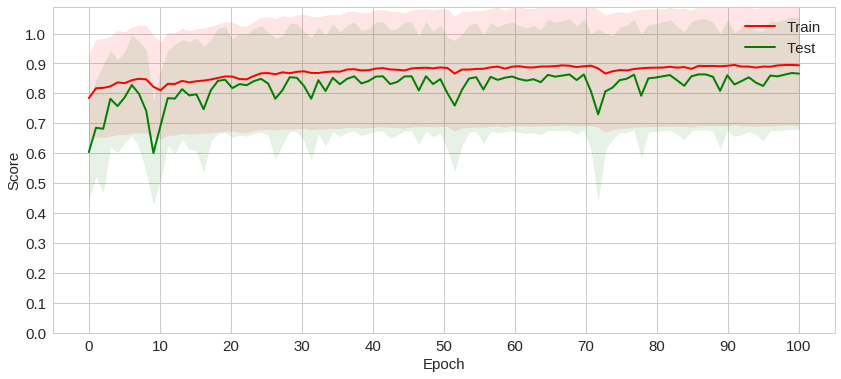

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

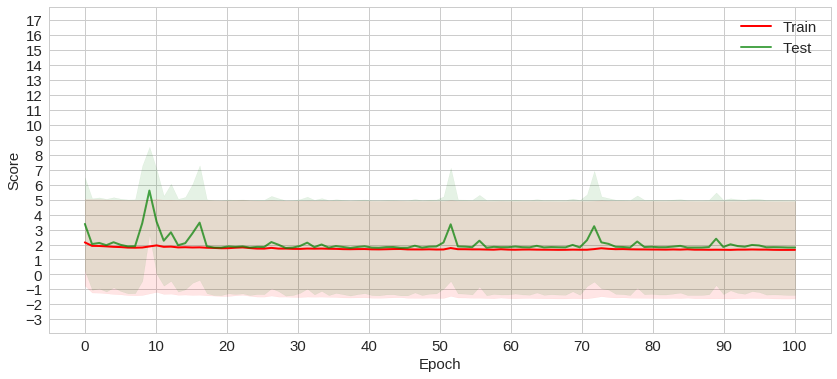

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-5, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

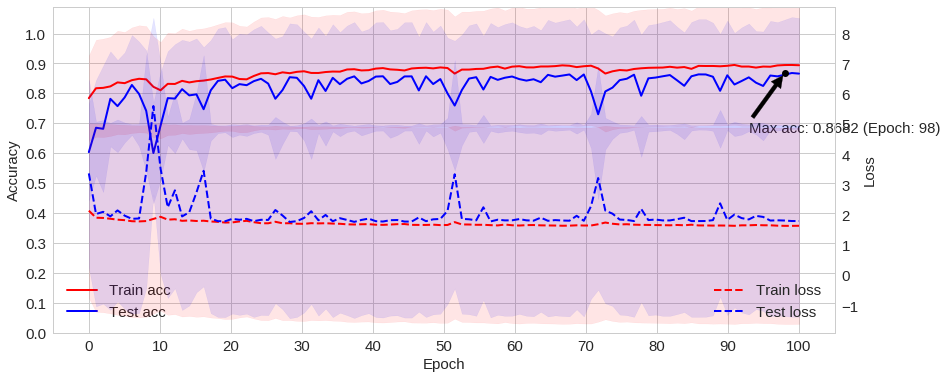

In [28]:
plot_mean(hist)